In [ ]:
%load_ext autoreload
%autoreload 2
%env CUDA_VISIBLE_DEVICES=0
import os, sys
import time
sys.path.insert(0, '..')
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import lib
import torch, torch.nn as nn
import torch.nn.functional as F

device = 'cuda' if torch.cuda.is_available() else 'cpu'

experiment_name = 'a9a_node_8layers'
experiment_name = '{}_{}.{:0>2d}.{:0>2d}_{:0>2d}-{:0>2d}'.format(experiment_name, *time.gmtime()[:5])
print("experiment:", experiment_name)

print(torch.__version__, torch.cuda.is_available(), torch.version.cuda)
print(f"Device : {device}")


env: CUDA_VISIBLE_DEVICES=0
experiment: a9a_node_8layers_2025.10.01_14-57
2.5.1+cu121 True 12.1
Device : cuda


In [ ]:
# Load A9A data from local files
print("Loading A9A data from local files...")
from sklearn.datasets import load_svmlight_file
from sklearn.preprocessing import QuantileTransformer

# Load data from local files
train_path = '../data/A9A/a9a'
test_path = '../data/A9A/a9a.t'
print(f"Loading train data from: {train_path}")
print(f"Loading test data from: {test_path}")

# Load the datasets
X_train, y_train = load_svmlight_file(train_path, dtype=np.float32, n_features=123)
X_test, y_test = load_svmlight_file(test_path, dtype=np.float32, n_features=123)

# Convert to dense arrays
X_train = X_train.toarray()
X_test = X_test.toarray()

# Convert labels from {-1, +1} to {0, 1}
y_train = (y_train + 1) // 2  # Convert -1->0, +1->1
y_test = (y_test + 1) // 2

print(f"Train data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")
print(f"Train labels: {np.unique(y_train, return_counts=True)}")
print(f"Test labels: {np.unique(y_test, return_counts=True)}")

# Load stratified indices
train_idx_path = '../data/A9A/stratified_train_idx.txt'
valid_idx_path = '../data/A9A/stratified_valid_idx.txt'

train_indices = np.loadtxt(train_idx_path, dtype=int)
valid_indices = np.loadtxt(valid_idx_path, dtype=int)

print(f"Train indices: {len(train_indices)}")
print(f"Valid indices: {len(valid_indices)}")

# Create train/validation splits
X_train_split = X_train[train_indices]
y_train_split = y_train[train_indices]
X_valid = X_train[valid_indices]
y_valid = y_train[valid_indices]

print(f"Train split: {X_train_split.shape}")
print(f"Valid split: {X_valid.shape}")

# Apply quantile transform
print("Applying quantile transform...")
qt = QuantileTransformer(output_distribution='normal', random_state=1337)
X_train_split = qt.fit_transform(X_train_split)
X_valid = qt.transform(X_valid)
X_test = qt.transform(X_test)

# Create data object similar to lib.Dataset
class Data:
    def __init__(self, X_train, y_train, X_valid, y_valid, X_test, y_test):
        self.X_train = X_train
        self.y_train = y_train
        self.X_valid = X_valid
        self.y_valid = y_valid
        self.X_test = X_test
        self.y_test = y_test

data = Data(X_train_split, y_train_split, X_valid, y_valid, X_test, y_test)

in_features = data.X_train.shape[1]
print(f"Features: {in_features}")
print(f"Train samples: {len(data.X_train)}")
print(f"Valid samples: {len(data.X_valid)}")
print(f"Test samples: {len(data.X_test)}")


Loading A9A data from local files...
Loading train data from: ../data/A9A/a9a
Loading test data from: ../data/A9A/a9a.t
Train data shape: (32561, 123)
Test data shape: (16281, 123)
Train labels: (array([0., 1.]), array([24720,  7841]))
Test labels: (array([0., 1.]), array([12435,  3846]))
Train indices: 26048
Valid indices: 6513
Train split: (26048, 123)
Valid split: (6513, 123)
Applying quantile transform...
Features: 123
Train samples: 26048
Valid samples: 6513
Test samples: 16281


In [ ]:
# Model architecture (8 layers)
model = nn.Sequential(
    lib.DenseBlock(in_features, 128, num_layers=8, tree_dim=3, depth=6, flatten_output=False,
                   choice_function=lib.entmax15, bin_function=lib.entmoid15),
    lib.Lambda(lambda x: x[..., 0].mean(dim=-1)),
).to(device)

print(f"Model parameters: {sum(p.numel() for p in model.parameters())}")
print(f"Model device: {next(model.parameters()).device}")


Model parameters: 9228296
Model device: cuda:0


In [ ]:
# Training setup
from qhoptim.pyt import QHAdam

optimizer_params = {
    'lr': 0.01,
    'nus': (0.7, 1.0),
    'betas': (0.95, 0.998)
}

trainer = lib.Trainer(
    model=model, loss_function=F.binary_cross_entropy_with_logits,
    experiment_name=experiment_name,
    warm_start=False,
    Optimizer=QHAdam,
    optimizer_params=optimizer_params,
    verbose=True,
    n_last_checkpoints=5
)

print(f"Trainer created for experiment: {experiment_name}")


Trainer created for experiment: a9a_node_8layers_2025.10.01_14-57


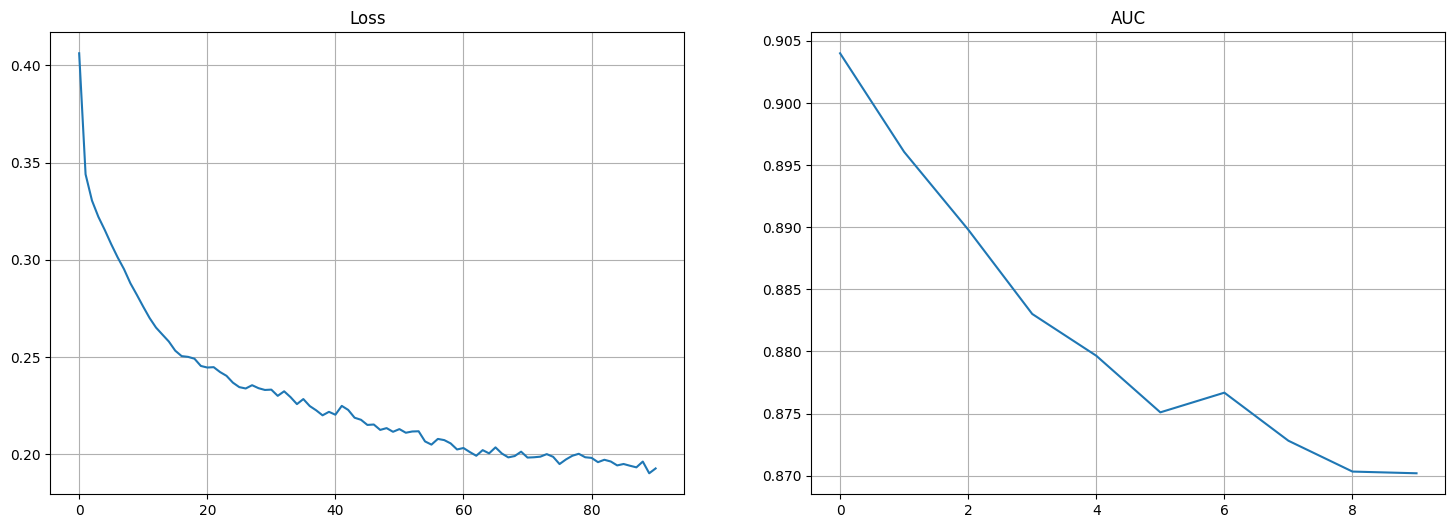

Epoch 90: Loss=0.1928, AUC=0.8702, Best AUC=0.9040
Training completed. Best AUC: 0.9040


In [ ]:
# Training loop
from IPython.display import clear_output
import matplotlib.pyplot as plt

# Set CUDA memory management
if torch.cuda.is_available():
    os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
    torch.cuda.empty_cache()

loss_history = []
auc_history = []
best_auc = 0.0

for epoch in range(100):
    # Training
    model.train()
    epoch_losses = []
    
    for batch in lib.iterate_minibatches(data.X_train, data.y_train, batch_size=256, shuffle=True):
        loss_dict = trainer.train_on_batch(*batch, device=device)
        epoch_losses.append(loss_dict['loss'].item())
    
    avg_loss = np.mean(epoch_losses)
    loss_history.append(avg_loss)
    
    # Evaluation
    if epoch % 10 == 0:
        # Clear cache before evaluation
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        
        # Evaluate AUC on validation set
        auc = trainer.evaluate_auc(
            data.X_valid, data.y_valid, device=device, 
            batch_size=1024, use_amp=True
        )
        auc_history.append(auc)
        
        if auc > best_auc:
            best_auc = auc
            trainer.save_checkpoint(tag='best')
        
        # Save checkpoint
        trainer.save_checkpoint()
        
        # Plotting
        clear_output(True)
        plt.figure(figsize=[18, 6])
        plt.subplot(1, 2, 1)
        # Convert tensors to numpy arrays for plotting
        loss_plot = [loss.detach().cpu().numpy() if hasattr(loss, 'detach') else loss for loss in loss_history]
        plt.plot(loss_plot)
        plt.title('Loss')
        plt.grid()
        plt.subplot(1, 2, 2)
        # Convert tensors to numpy arrays for plotting
        auc_plot = [auc.detach().cpu().numpy() if hasattr(auc, 'detach') else auc for auc in auc_history]
        plt.plot(auc_plot)
        plt.title('AUC')
        plt.grid()
        plt.show()
        
        print(f"Epoch {epoch}: Loss={avg_loss:.4f}, AUC={auc:.4f}, Best AUC={best_auc:.4f}")
        
        # Early stopping
        if len(auc_history) > 10:
            if auc_history[-1] < max(auc_history[-10:]) - 0.001:
                print("Early stopping triggered")
                break

print(f"Training completed. Best AUC: {best_auc:.4f}")


In [ ]:
# Final evaluation
print("Final evaluation...")

# Load best checkpoint
trainer.load_checkpoint(tag='best')

# Clear cache before evaluation
if torch.cuda.is_available():
    torch.cuda.empty_cache()

# Evaluate on test set
test_auc = trainer.evaluate_auc(
    data.X_test, data.y_test, device=device, 
    batch_size=1024, use_amp=True
)

test_error = trainer.evaluate_classification_error(
    data.X_test, data.y_test, device=device, 
    batch_size=1024, use_amp=True
)

print(f"Test AUC: {test_auc:.4f}")
print(f"Test Error Rate: {test_error:.4f}")

# Save results
results = {
    'experiment_name': experiment_name,
    'dataset': 'A9A',
    'model_config': '8_layers',
    'test_auc': float(test_auc),
    'test_error_rate': float(test_error),
    'best_validation_auc': float(best_auc),
    'final_epoch': len(loss_history)
}

print("Results:", results)


Final evaluation...
Loaded logs/a9a_node_8layers_2025.10.01_14-57\checkpoint_best.pth


e:\Hari\node\notebooks\..\lib\trainer.py:73: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path)
e:\Hari\node\notebooks\..\lib\trainer.py:183: Future

Test AUC: 0.9026
Test Error Rate: 0.1501
Results: {'experiment_name': 'a9a_node_8layers_2025.10.01_14-57', 'dataset': 'A9A', 'model_config': '8_layers', 'test_auc': 0.9025808567525653, 'test_error_rate': 0.15011362938394449, 'best_validation_auc': 0.9039988146637439, 'final_epoch': 100}
